In [1]:
import warnings
warnings.filterwarnings('ignore')

In [20]:
# import required libraries
import json
import numpy as np
import pandas as pd
import re
import string

# Plotting
import matplotlib.pyplot as plt
# plt.style.use('fivethirtyeight')
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import seaborn as sns

In [21]:
# Read saved clean dataset
df = pd.read_csv("C://GoogleDrive/dissertation/data/output/all_tweets_clean.csv")

# Check first 2 rows
df.head(2)

,retwtcnt,hashtagcnt,hashtags,mentioncnt,mentions,urlcnt,usrname,acntage,twtcnt,usrvrfd,usrloc,label,text,wrdcnt,uwrdcnt,mwrdlngth,chrcnt,puncnt
0,0,0,nohashtags,0,nomentions,1,richx,4110,35284,False,stirlingshire vancouver,real,large meeting event need order mass gathering ...,28,22,3.964286,144,6
1,0,0,nohashtags,2,rumpelstinski sanidadgob,1,angelaluna,3583,1552,False,nousrloc,real,recommend international mass gatherings cancel...,15,15,8.400000,140,8


## Check the density of the metadata features if they gives any pattern 
***

Based on this check the features would be considered or not for the study. 

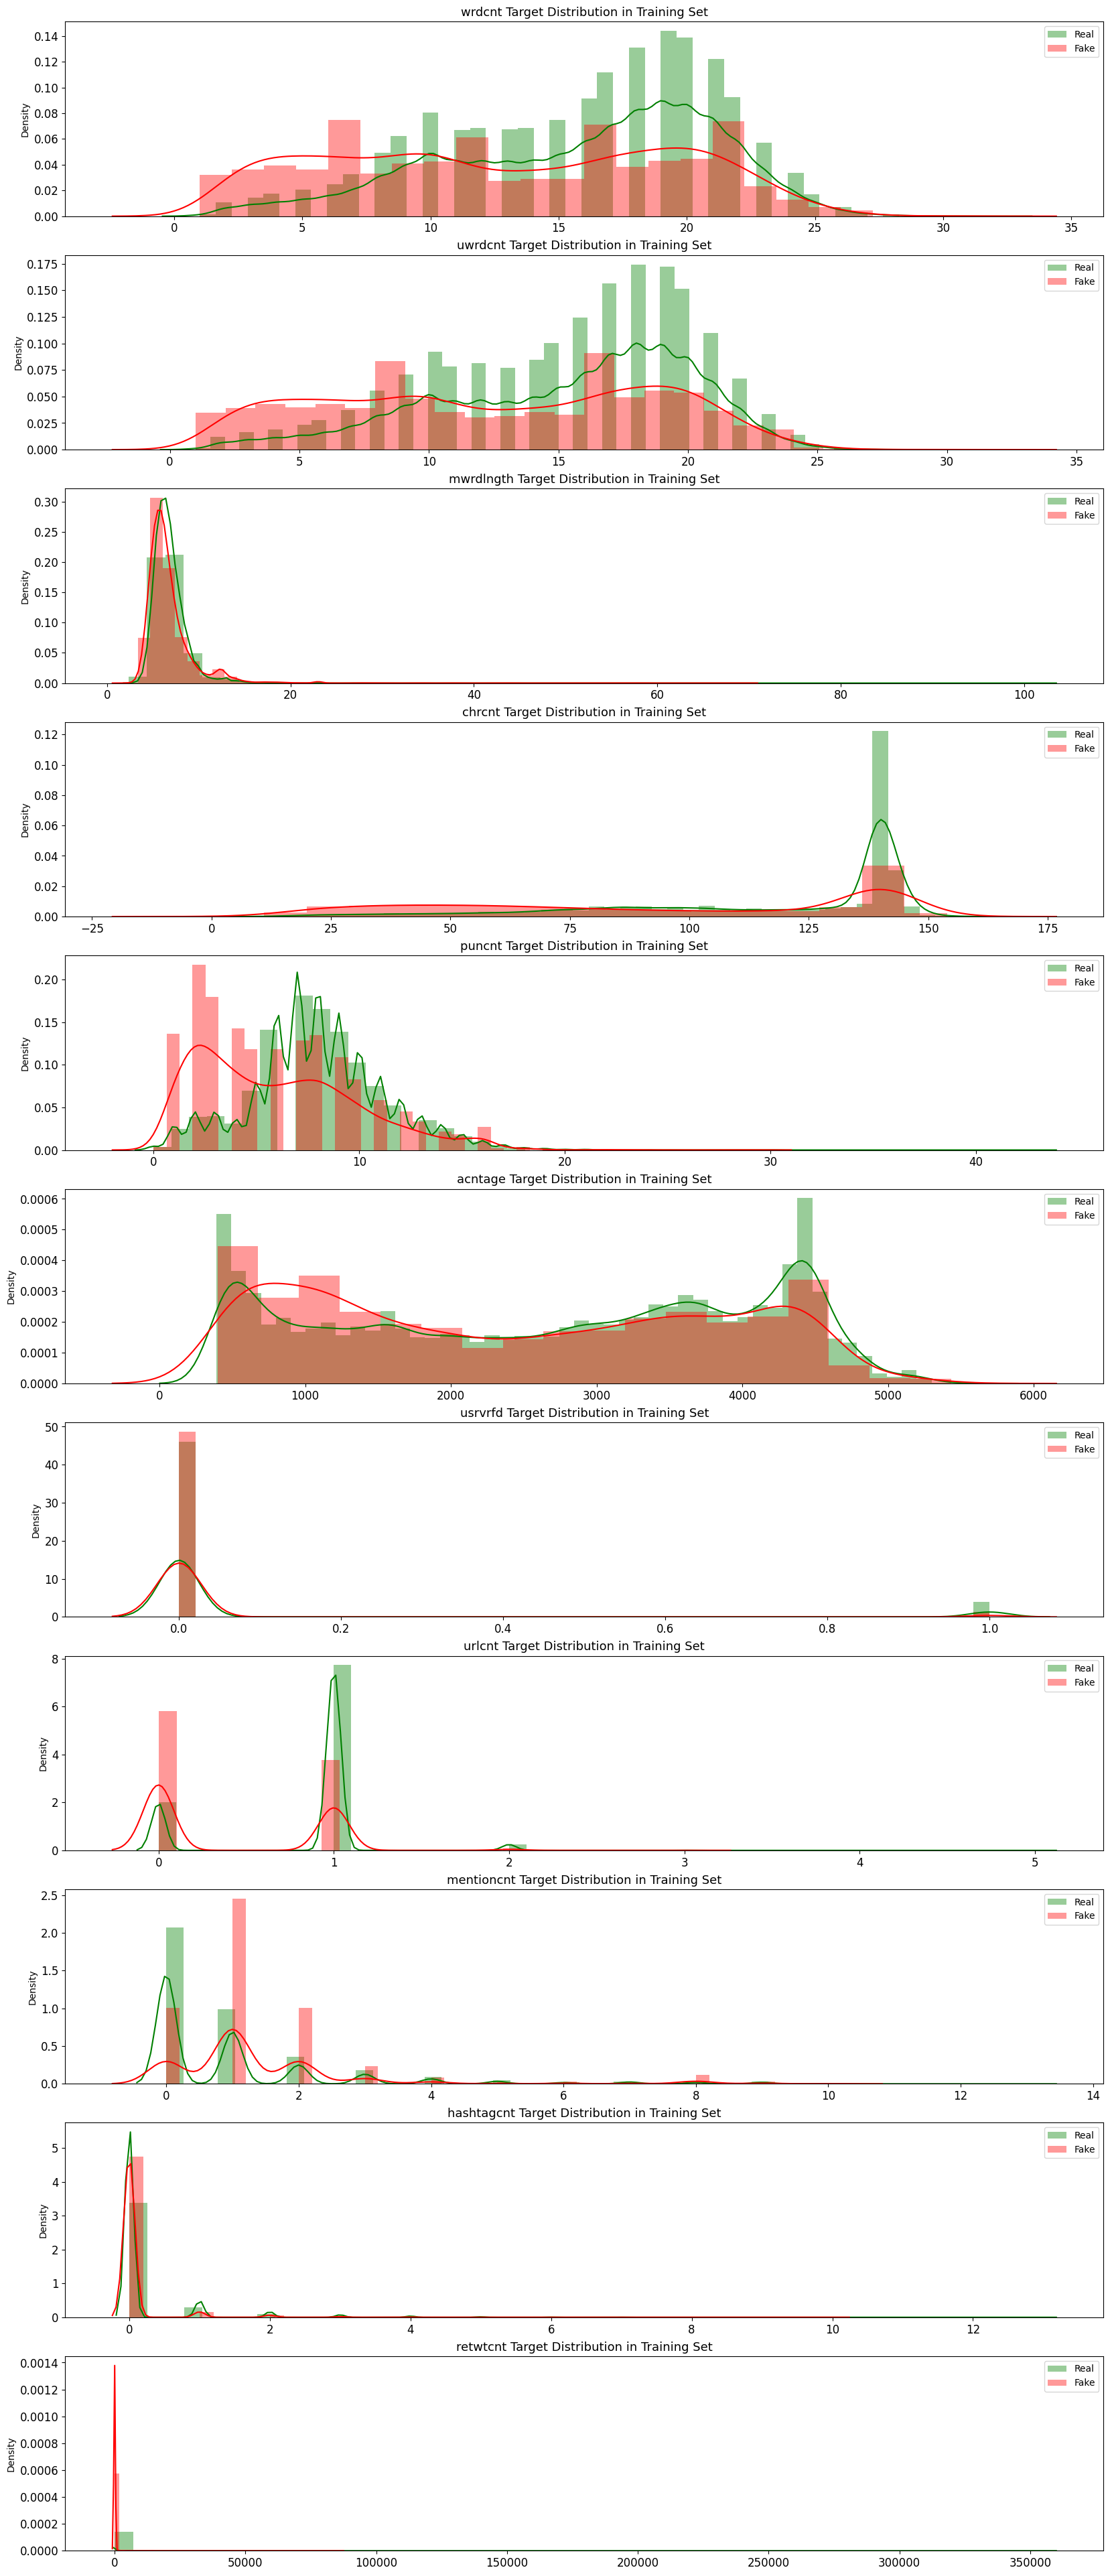

In [4]:
METAFEATURES = ['wrdcnt', 'uwrdcnt', 'mwrdlngth', 'chrcnt',
                'puncnt', 'acntage','usrvrfd', 'urlcnt', 
                'mentioncnt','hashtagcnt', 'retwtcnt']
FAKE_TWEETS = df['label'] == 'fake'
fig, canvases = plt.subplots(ncols=1, nrows=len(METAFEATURES), figsize=(20, 50), dpi=100)
for i, feature in enumerate(METAFEATURES):
    sns.distplot(df.loc[~FAKE_TWEETS][feature], label='Real', ax=canvases[i], color='green')
    sns.distplot(df.loc[FAKE_TWEETS][feature], label='Fake', ax=canvases[i], color='red')
    canvases[i].set_xlabel('')
    canvases[i].tick_params(axis='x', labelsize=12)
    canvases[i].tick_params(axis='y', labelsize=12)
    canvases[i].legend()
    canvases[i].set_title(f'{feature} Target Distribution in Training Set', fontsize=13)
plt.show()

## Merge all text columns to one
***

### Check if none of the text columns have the missing values
***

If found any, perform impute operation

In [4]:
# Check if any missing values columns contain
df.isna().sum()

retwtcnt         0
hashtagcnt       0
hashtags       217
mentioncnt       0
mentions       588
urlcnt           0
usrname        490
acntage          0
twtcnt           0
usrvrfd          0
usrloc        4085
label            0
text          3997
wrdcnt           0
uwrdcnt          0
mwrdlngth        0
chrcnt           0
puncnt           0
dtype: int64

Found muliple columns with missing values - hashtags; mentions; usrname; usrloc; text;                          

In [22]:
# remove missing values from the columns by imputation
df.hashtags.fillna('nohashtag', inplace=True)
df.mentions.fillna('nomention', inplace=True)
df.usrname.fillna('nousrname', inplace=True)
df.usrloc.fillna('nousrloc', inplace=True)
df.text.fillna('notext',inplace=True)

# Check if any missing values columns contain
df.isna().sum()

retwtcnt      0
hashtagcnt    0
hashtags      0
mentioncnt    0
mentions      0
urlcnt        0
usrname       0
acntage       0
twtcnt        0
usrvrfd       0
usrloc        0
label         0
text          0
wrdcnt        0
uwrdcnt       0
mwrdlngth     0
chrcnt        0
puncnt        0
dtype: int64

### Now transformed the or merge the data
***

In [23]:
def set_char_code(cnt):
    if (cnt < 75):
        return "small"
    elif (cnt >= 75 and cnt < 138):
        return "medium"
    elif (cnt > 137 and cnt < 141):
        return "large"
    else:
        return "very large"

In [24]:
# consolidate all text columns to one
df['txt'] = df['text']+' '+df['hashtags']+' '+df['mentions']+' '+df['usrname']+' '+df['usrloc']

# transform wrdcnt to word size - small (0) if less than 11 else large (1)
df['wrdsize'] = df.wrdcnt.apply(lambda cnt: 'small' if cnt < 11 else 'large')

# transform urlcnt to binary - either present or absence from tweet
df['url'] = df.urlcnt.apply(lambda cnt: 'present' if cnt == 0 else 'absent')

# mention transform to binary - either present or absence from tweet
df['mention'] = df.mentioncnt.apply(lambda cnt: 'present' if cnt == 0 else 'absent')

# transform to categorical - four sizes
df['charsize'] = df.chrcnt.apply(lambda cnt: set_char_code(cnt))

# transform to binary - less number or more number
df['puncsize'] = df.puncnt.apply(lambda cnt: 'less' if cnt < 5 else 'more')

In [25]:
# create list of all columns that needed to be dropped from the final dataset
drop_cols = ['text', 'hashtags', 'mentions', 'usrname', 'usrloc', 'wrdcnt', 'uwrdcnt', 
              'mwrdlngth', 'chrcnt', 'urlcnt', 'mentioncnt', 'hashtagcnt', 'puncnt', 
             'acntage', 'twtcnt','retwtcnt']

# drop columns
df.drop(columns=drop_cols, axis=1, inplace=True)

In [26]:
df.head(2) 

,usrvrfd,label,txt,wrdsize,url,mention,charsize,puncsize
0,False,real,large meeting event need order mass gathering ...,large,absent,present,very large,more
1,False,real,recommend international mass gatherings cancel...,large,absent,absent,large,more


## Check duplicate records 
***

In [27]:
# get duplicate counts for fake tweets before duplicate removal
nfaketwts_shape_bdup = df[df['label'] == 'fake'].shape[0]

# get duplicate counts for real tweets before duplicate removal
nrealtwts_shape_bdup = df[df['label'] == 'real'].shape[0]

# check if any duplicate exist before removal
print('Total duplicate records: {}'.format(df['txt'].duplicated().sum()))

# remove duplicates 
df = df[df.txt.duplicated() == False]

# check if any duplicate exist after removal
print('Total duplicate records (after duplicate removal): {}'.format(df['txt'].duplicated().sum()))

# get duplicate counts for real tweets after duplicate removal
nrealtwts_shape_adup = df[df['label'] == 'real'].shape[0]

# get duplicate counts for fake tweets after duplicate removal
nfaketwts_shape_adup = df[df['label'] == 'fake'].shape[0]

print('Total FAKE tweets count before and after duplicate removal: {} & {} '.format(nfaketwts_shape_bdup, nfaketwts_shape_adup))
print('Total REAL tweets count before and after duplicate removal: {} & {} '.format(nrealtwts_shape_bdup, nrealtwts_shape_adup))

Total duplicate records: 9908
Total duplicate records (after duplicate removal): 0
Total FAKE tweets count before and after duplicate removal: 6618 & 6346 
Total REAL tweets count before and after duplicate removal: 157362 & 147726 


In [71]:
# Test if duplicate exist
df[df.txt == 'notext nohashtags conflictsw lealokkk global mil info dewsnewz iscresearch cnn drtedros offlimitsnews zyrofoxtrot texas']

,usrvrfd,label,txt,wrdsize,url,mention,charsize,puncsize
163240,False,fake,notext nohashtags conflictsw lealokkk global m...,small,absent,absent,medium,more


In [111]:
df[:2].txt

0    large meeting event need order mass gathering ...
1    recommend international mass gatherings cancel...
Name: txt, dtype: object

## Data encoding
***

### One hot encoding for all the categorical data
***

In [28]:
#categorical data
cat_columns = ['wrdsize', 'url', 'mention', 'charsize', 'puncsize', 'usrvrfd']

#import pandas as pd
df_encode = pd.get_dummies(df, columns = cat_columns)

# display output
df_encode.head(2)

,label,txt,wrdsize_large,wrdsize_small,url_absent,url_present,mention_absent,mention_present,charsize_large,charsize_medium,charsize_small,charsize_very large,puncsize_less,puncsize_more,usrvrfd_False,usrvrfd_True
0,real,large meeting event need order mass gathering ...,1,0,1,0,0,1,0,0,0,1,0,1,1,0
1,real,recommend international mass gatherings cancel...,1,0,1,0,1,0,1,0,0,0,0,1,1,0


In [31]:
df_notxt = df_encode.drop(columns='txt', axis=1)

from sklearn.preprocessing import LabelEncoder

# create label encoder object
lbl_encoder = LabelEncoder()

# encode label feature to 0 and 1
df_notxt.label = lbl_encoder.fit_transform(df_notxt.label)

In [33]:
df_notxt.corr()

,label,wrdsize_large,wrdsize_small,url_absent,url_present,mention_absent,mention_present,charsize_large,charsize_medium,charsize_small,charsize_very large,puncsize_less,puncsize_more,usrvrfd_False,usrvrfd_True
label,1.000000,0.108352,-0.108352,0.200871,-0.200871,-0.132816,0.132816,0.071561,0.028916,-0.169712,0.031410,-0.185847,0.185847,-0.036404,0.036404
wrdsize_large,0.108352,1.000000,-1.000000,0.335080,-0.335080,-0.082225,0.082225,0.402360,-0.041584,-0.686878,0.185925,-0.337992,0.337992,-0.084420,0.084420
wrdsize_small,-0.108352,-1.000000,1.000000,-0.335080,0.335080,0.082225,-0.082225,-0.402360,0.041584,0.686878,-0.185925,0.337992,-0.337992,0.084420,-0.084420
url_absent,0.200871,0.335080,-0.335080,1.000000,-1.000000,-0.346518,0.346518,0.413755,-0.176464,-0.525635,0.191392,-0.748436,0.748436,-0.070355,0.070355
url_present,-0.200871,-0.335080,0.335080,-1.000000,1.000000,0.346518,-0.346518,-0.413755,0.176464,0.525635,-0.191392,0.748436,-0.748436,0.070355,-0.070355
mention_absent,-0.132816,-0.082225,0.082225,-0.346518,0.346518,1.000000,-1.000000,0.011107,-0.042488,0.167854,-0.132269,0.271253,-0.271253,0.136466,-0.136466
mention_present,0.132816,0.082225,-0.082225,0.346518,-0.346518,-1.000000,1.000000,-0.011107,0.042488,-0.167854,0.132269,-0.271253,0.271253,-0.136466,0.136466
charsize_large,0.071561,0.402360,-0.402360,0.413755,-0.413755,0.011107,-0.011107,1.000000,-0.576700,-0.331245,-0.310006,-0.316153,0.316153,-0.083008,0.083008
charsize_medium,0.028916,-0.041584,0.041584,-0.176464,0.176464,-0.042488,0.042488,-0.576700,1.000000,-0.286341,-0.267981,0.023336,-0.023336,0.066340,-0.066340
charsize_small,-0.169712,-0.686878,0.686878,-0.525635,0.525635,0.167854,-0.167854,-0.331245,-0.286341,1.000000,-0.153923,0.554698,-0.554698,0.066733,-0.066733


### Class balancing - down scaling
***

In [37]:
import seaborn as sns
import numpy as np

totreal = df_encode.label[df_encode.label == 'real'].count()
totfake = df_encode.label[df_encode.label == 'fake'].count()

# tweets.Label
print('Real tweets percentage:', str(round(totreal/df_encode.shape[0], 2)*100),'%')
print('Fake tweets percentage:', str(round(totfake/df_encode.shape[0], 2)*100),'%')

Real tweets percentage: 96.0 %
Fake tweets percentage: 4.0 %


In [11]:
def stratified_sample_df(df, col, n_samples):
    n = min(n_samples, df[col].value_counts().min())
    df_ = df.groupby(col).apply(lambda x: x.sample(n))
    df_.index = df_.index.droplevel(0)
    return df_

temp = stratified_sample_df(df_encode, 'label', 100)
temp

### Data imbalancing
https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets

In [38]:
# original counts
print('REAL COUNT:',totreal,'\nFAKE COUNT:', totfake)

# consider if fake tweets count is 30% of real count then the real count should be scaledRealCnt
scaledRealCnt = round((totfake/30) * 100, 0)

print('-----------------------------------------------------------')

# select scaled real tweets randomly
randRealTwts = df_encode[df_encode.label == 'real'].sample(n = int(scaledRealCnt))

# select all fake tweets in a variable
fakeTwts = df_encode[df_encode.label == 'fake']

# Check 30/70 ratio counts 
print('REAL COUNT (70%):',randRealTwts.shape[0],'\nFAKE COUNT (30%):', fakeTwts.shape[0])
print('-----------------------------------------------------------')

# Concatenate real and fake in 30/70 ratio
print('Shape before merge', randRealTwts.shape[0],randRealTwts.shape[1] ,'&',fakeTwts.shape[0], fakeTwts.shape[1])
balancedTwts = pd.concat([randRealTwts, fakeTwts], axis=0)
print('Shape after merge', balancedTwts.shape)
print('-----------------------------------------------------------')

# generate 30/70 ratio clean csv file for further processing
# balancedTwts.to_csv("C://GoogleDrive/dissertation/data/output/all_tweets_balanced.csv", index=False)
# print("all_tweets_balanced file got created inside:\n", "C://GoogleDrive/dissertation/data/output/")

REAL COUNT: 147726 
FAKE COUNT: 6346
-----------------------------------------------------------
REAL COUNT (70%): 21153 
FAKE COUNT (30%): 6346
-----------------------------------------------------------
Shape before merge 21153 16 & 6346 16
Shape after merge (27499, 16)
-----------------------------------------------------------


## Encode the text and label data too
***

### Text data encoding using TF-IDF
***

In [39]:
balancedTwts.txt.isna().sum()

0

## New way
***

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer

# create an object of tfid vectorizer
tfidf_vctrzr=TfidfVectorizer(max_features=5000, ngram_range=(1,1))

# fit the vectorizer to X
twts = balancedTwts.txt

# check if any txt is empty
if twts.isna().sum() > 0:
    twts.fillna('notext', inplace=True)

tfidf_vctrzr.fit(twts)

# transform the X to sparse matrix
sparse_mtrx = tfidf_vctrzr.transform(twts).toarray()

# get all the features from the vectorizer
col_features = tfidf_vctrzr.get_feature_names()

# get matrix in df
mtrx_df = pd.DataFrame(data=sparse_mtrx, columns=col_features)

## Old way
***

In [44]:
# declare tfidf vectorizer object with maximum features set to 5000
Tfidf_vect = TfidfVectorizer(max_features=5000)

# "fit" computes the mean and std to be used for later scaling. (just a computation), nothing is given to you. 
features_Tfidf = Tfidf_vect.fit(balancedTwts.txt)

# "transform" uses a previously computed mean and std to autoscale the data (subtract mean from all values and then divide it by std)
features_Tfidf = Tfidf_vect.transform(balancedTwts.txt)

# For testing set, Machine learning applies prediction based on what was learned during the training set and so it doesn't need to calculate, it just performs the transformation.
# test_features_Tfidf = Tfidf_vect.transform(test_features)

In [57]:
# concatinate both the dataframes
df_final = pd.concat([features_Tfidf,balancedTwts.drop(['txt'],axis=1).reset_index()],axis=1)

# df_final = pd.concat([mtrx_df.reset_index(),balancedTwts.drop(['txt'],axis=1).reset_index()],axis=1)
df_final

TypeError: cannot concatenate object of type '<class 'scipy.sparse.csr.csr_matrix'>'; only Series and DataFrame objs are valid

In [48]:
features_Tfidf.shape, balancedTwts.label.shape

((27499, 5000), (27499,))

In [50]:
trn_labels = balancedTwts.label.values.ravel()
print(type(features_Tfidf), type(trn_labels))

<class 'scipy.sparse.csr.csr_matrix'> <class 'numpy.ndarray'>


In [54]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix

# split dataset into training and test 
X_train, X_test, y_train, y_test = train_test_split(features_Tfidf,trn_labels, test_size=0.33, random_state=12)

In [55]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train,y_train)

# predict the labels on validation dataset
pred_lr = lr.predict(X_test)

# Use accuracy_score function to get the accuracy
print("Random forest Accuracy without performance tuning -> ",accuracy_score(pred_lr, y_test)*100)

Random forest Accuracy without performance tuning ->  88.11019283746556


### Label encoding using LabelEncoder
***

In [46]:
from sklearn.preprocessing import LabelEncoder

# create label encoder object
lbl_encoder = LabelEncoder()

# encode label feature to 0 and 1
balancedTwts.label = lbl_encoder.fit_transform(balancedTwts.label)

### Concatenate categorical, textual and label data into single frame
***

In [16]:
# concatinate both the dataframes
df_final = pd.concat([mtrx_df.reset_index(),balancedTwts.drop(['txt'],axis=1).reset_index()],axis=1)

# df_final = pd.concat([mtrx_df.reset_index(),balancedTwts.drop(['txt'],axis=1).reset_index()],axis=1)
df_final

,index,ab,abadiaen,abc,ability,able,abo,aboard,abou,absolute,...,mention_absent,mention_present,charsize_large,charsize_medium,charsize_small,charsize_very large,puncsize_less,puncsize_more,usrvrfd_False,usrvrfd_True
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,1,0,0,0,0,1,0,1
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,1,0,0,0,0,1,1,0
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,1,0,0,1,0,1,0
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,1,0,0,0,1,1,0
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,1,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12687,12687,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,1,0,0,0,1,1,0
12688,12688,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,1,0,0,1,0,1,0
12689,12689,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,1,0,0,1,0,1,0
12690,12690,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,1,0,0,1,1,0


In [17]:
mtrx_df.shape, balancedTwts.shape, df_final.shape

((12692, 5000), (12692, 16), (12692, 5017))

In [18]:
for key, val in tfidf_vctrzr.vocabulary_.items():
    if (key == 'nomentions' or key == 'nohashtags' or key == 'notext' or key == 'nousrloc'):
        print(key, val)
# [2900:3100]

nohashtags 3045
nomentions 3047
nousrloc 3074
notext 3067


### Save the final dataset in the encoded form to the csv file for later use
***

In [19]:
df_final.to_csv("C://GoogleDrive/dissertation/data/output/all_tweets_encoded.csv", index=False)
print("all_tweets_encoded file got created inside:\n", "C://GoogleDrive/dissertation/data/output/")

all_tweets_encoded file got created inside:
 C://GoogleDrive/dissertation/data/output/
